In [1]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

Using device: cuda


'2.0.0+cu117'

### Customiza parametros da rede neural profunda equivariante

In [2]:
def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 10
    args.margin_loss = 2.0
    args.border  = 3
    args.exported = False
    return args

### Prepara dataloader transformado (preprocessamento)
- cria script de preprocessamento
- cria dataset e data load
- recupera o primeiro lote de dados

In [3]:
    num_bin = 3
    args = custom_config(args)
    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                             shuffle=False, num_workers=2)

In [4]:
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

10 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Carrega modelo e realiza a predição
- carrega modelo treinado (deteccao e orientacao)
- realiza predição
- aplica data argumentation sobre os dados de entrada e saida
- realiza predicao sobre os dados transformados

In [5]:
from training import KeyEqGroup, KeyPointsSelection, remove_borders, random_augmentation, shifted_batch_tensor
from utils import load_model, imshow, imshow2, imshow3,NMSHead,get_features
MODEL_PATH = "./data/models/model_flowers_ssim.pt"

model = load_model_trained(args,device,path=MODEL_PATH)

/home/wagner/PycharmProjects/torch_venv/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 39 loss 1.6361578539306043


In [6]:
_kp1, _orie1 = model(img_batch.to(device))
_kp1.shape,_orie1.shape,type(_kp1),type(_orie1)

(torch.Size([10, 1, 180, 180]),
 torch.Size([10, 36, 180, 180]),
 torch.Tensor,
 torch.Tensor)

In [7]:
points = torch.randn(img_batch.shape[0], 2,
                     2).to(device)  # BxNx2 [x,y] pontos sinteticos so pra completar parametros

#cria mascara para remocao de borda
_B, _C, _W, _H = img_batch.shape
SIZE_BORDER = args.border
batch_mask = torch.zeros(_B, 1, _W, _H).to(device)
batch_mask[:, :, SIZE_BORDER:_W - SIZE_BORDER, SIZE_BORDER:_H - SIZE_BORDER] = 1
# aplica dataaugmentation
batch_image_pos_trans, feature_kp_anchor_trans, features_ori_anchor_trans, coords_trans, mask_trans = random_augmentation(
    img_batch,
    _kp1, _orie1,
    points,
    batch_mask)
# calcula as saidas sobre os dados transformados
_kp2, _orie2 = model(batch_image_pos_trans.to(device))
_kp2.shape,_orie2.shape,type(_kp2),type(_orie2)

(torch.Size([10, 1, 180, 180]),
 torch.Size([10, 36, 180, 180]),
 torch.Tensor,
 torch.Tensor)

### Visualizar o resultado dos mapas de ativações:
#### - magnitude
#### - orientação (max entre todos os filtros de grupo)

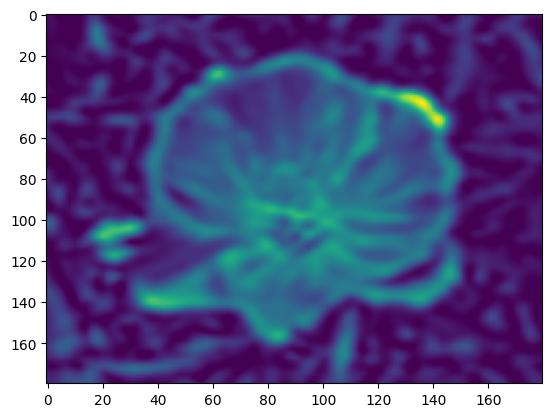

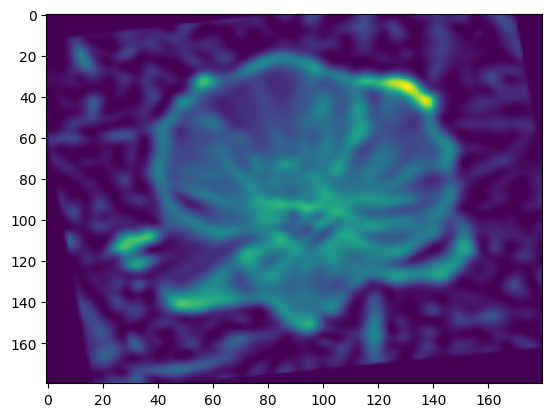

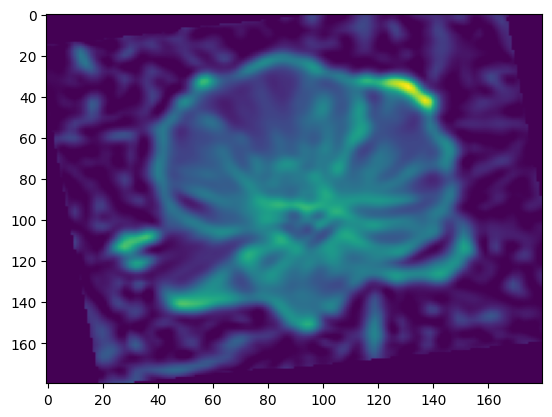

In [8]:
index = 5

plt.imshow(_kp1[index][0].cpu().detach(), aspect='auto')
plt.show()
plt.imshow(feature_kp_anchor_trans[index][0].cpu().detach(), aspect='auto')
plt.show()

_k2_mask=_kp2*mask_trans
plt.imshow(_k2_mask[index][0].cpu().detach(), aspect='auto')
plt.show()

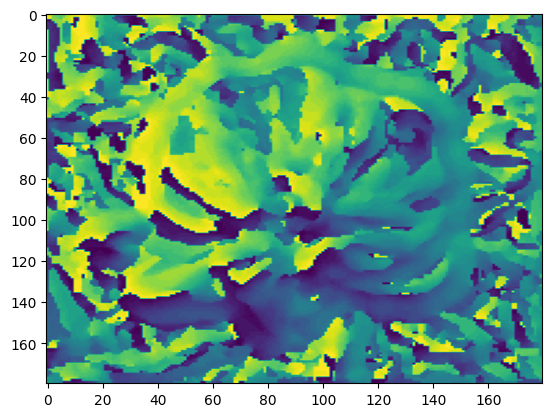

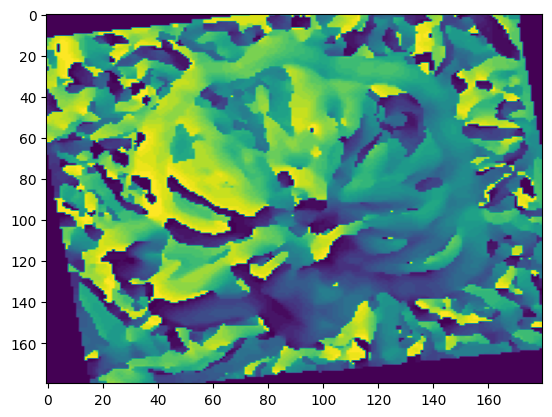

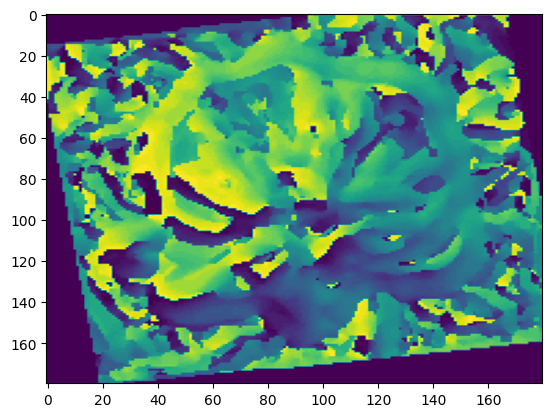

In [9]:
from predict import compute_gradient_direction

ori_arg_max= compute_gradient_direction(_orie1)
plt.imshow(ori_arg_max[index].cpu().detach(), aspect='auto')
plt.show()
features_ori_max= compute_gradient_direction(features_ori_anchor_trans)
plt.imshow(features_ori_max[index].cpu().detach(), aspect='auto')
plt.show()
_orie2_mask=_orie2*mask_trans
_ori2_arg_max= compute_gradient_direction(_orie2_mask)
plt.imshow(_ori2_arg_max[index].cpu().detach(), aspect='auto')
plt.show()

In [10]:
t =features_ori_max[index].cpu().detach()
print(t.shape,t[0,0],t[170,0],t.min(),t.max())

torch.Size([180, 180]) tensor(0.) tensor(0.) tensor(0.) tensor(350.)


### Computar um histograma que traz a magnitude x orientação

#### Somátorio da magnitude do gradiente no intervalo (bin) da direção
1. cria um filto (a) circular;
2. cria filtros (b) por intervalo da orientação sobre o mapa de ativação da orientação;
3. aplica a intercção entre os filtros (a) e (b) sobre o mapa de ativação da detecção;
4. realiza o somatorio dos itens filtrado e define como o valor do bin.
5. repete a partir do item 2 para cada bin do histograma.

180 180


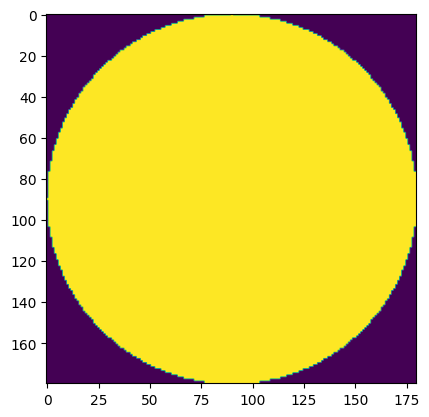

In [11]:
# filtro circular
from utils import create_circular_mask

circular_mask = create_circular_mask(_H,_W)
print(_H,_W)
plt.imshow(circular_mask)

((180, 180), (180, 180), numpy.ndarray, numpy.ndarray)

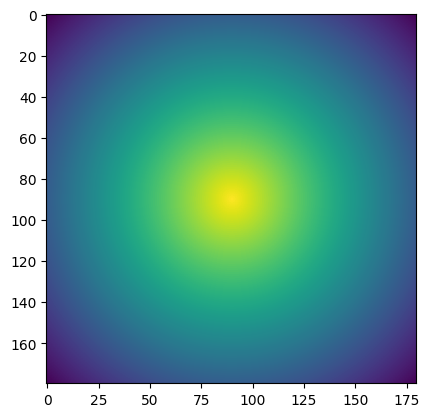

In [12]:
def my_normalize(df):
    dfmax, dfmin = df.max(), df.min()
    df = (df - dfmin)/(dfmax - dfmin)
    return df

def create_circular_mask2(_H,_W):
    # filtro por intervalo de orientação
    center = (int(_W / 2), int(_H / 2))
    Y, X = np.ogrid[:_H, :_W]
    mask = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    return 1-my_normalize(mask)

alternative_mask = create_circular_mask2(_H,_W)
plt.imshow(alternative_mask)
circular_mask.shape,alternative_mask.shape,type(circular_mask),type(alternative_mask)

torch.Size([10, 180, 180])


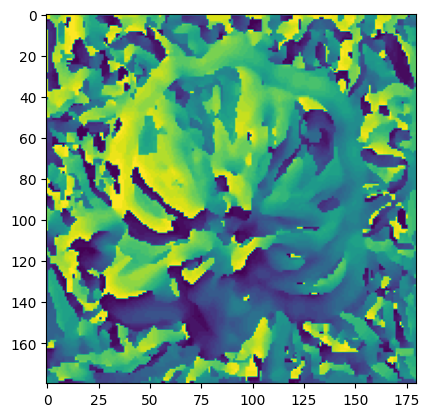

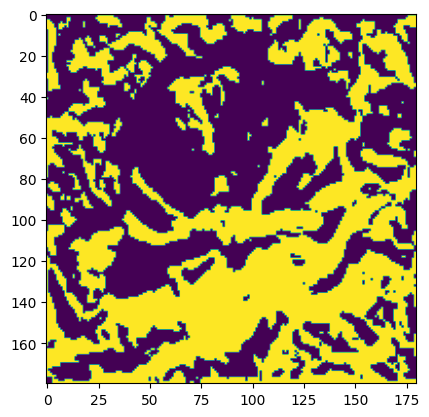

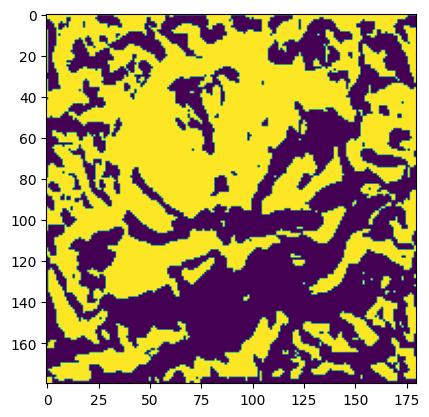

In [13]:
# filtros (b) por intervalo da orientação
def create_interval_mask(img,v0,v1):
    mask = (img>= v0) * (img<v1)
    return mask

print(ori_arg_max.shape)
plt.imshow(ori_arg_max[index].cpu().detach())
plt.show()

interval_mask = create_interval_mask(ori_arg_max,0,180)
plt.imshow(interval_mask[index].cpu().detach())
plt.show()

interval_mask2 = create_interval_mask(ori_arg_max,180,360)
plt.imshow(interval_mask2[index].cpu().detach())
plt.show()

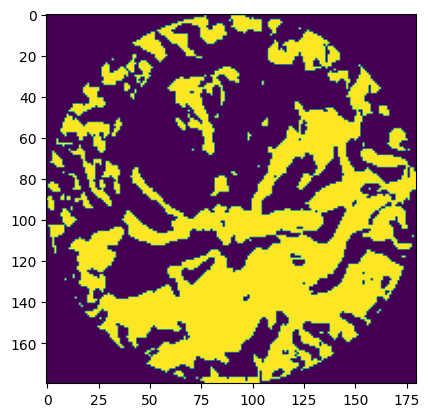

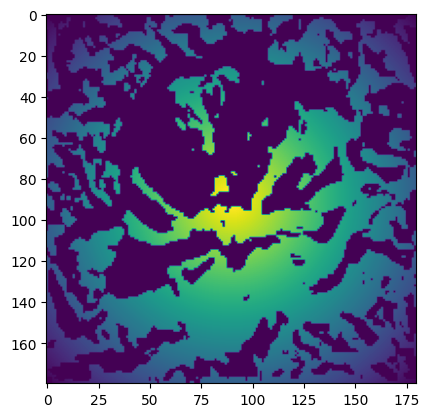

In [14]:
# aplicar intersecção entre os 2 filtros
def intersection_filter_interval_mask(interval_filter, circle_filter):
    inter_filter = interval_filter.to(device)*circle_filter.to(device)
    return inter_filter

mask_simples  = intersection_filter_interval_mask(interval_mask,torch.tensor(circular_mask[None]))
mask_alternative  = intersection_filter_interval_mask(interval_mask,torch.tensor(alternative_mask[None]))



plt.imshow(mask_simples[index].cpu().detach())
plt.show()


plt.imshow(mask_alternative[index].cpu().detach())
plt.show()

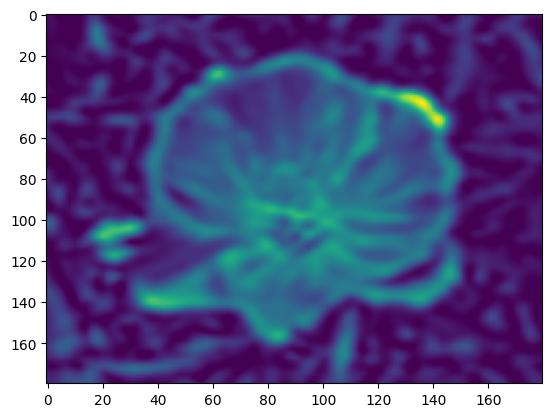

torch.Size([10, 1, 180, 180])


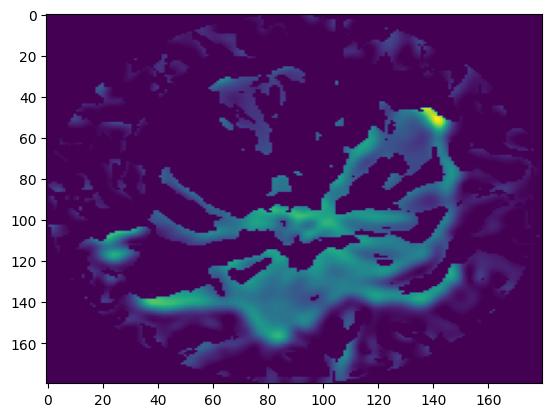

In [15]:
# computar somátorio entre os pixeis ativo pela filtragem
def sum_filtered_intensity(batch,filter):
    filter = filter[None].transpose(1,0)
    batch_filtered = batch * filter
    sum_batch = torch.sum(batch_filtered,dim=(2,3))
    return sum_batch,batch_filtered

plt.imshow(_kp1[index][0].cpu().detach(), aspect='auto')
plt.show()

sum_b, batch_filtered = sum_filtered_intensity(_kp1,mask_simples)
print(batch_filtered.shape)
plt.imshow(batch_filtered[index][0].cpu().detach(), aspect='auto')
plt.show()

#### Interar e construir um histograma com varios filtros de intervalo de bin

tensor(0., device='cuda:0') tensor(350., device='cuda:0')
<class 'numpy.ndarray'> (180, 180)
interval : 0  -  120


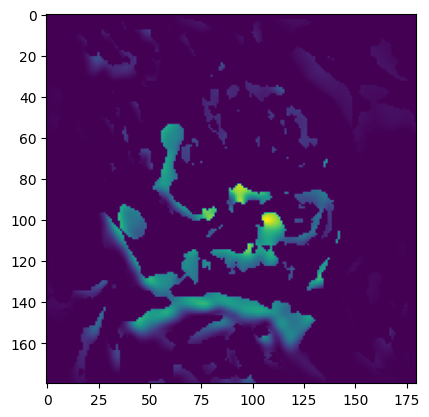

interval : 120  -  240


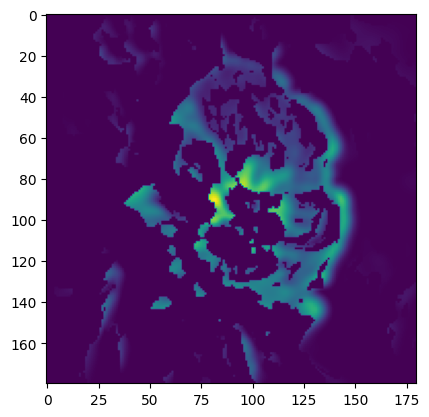

interval : 240  -  360


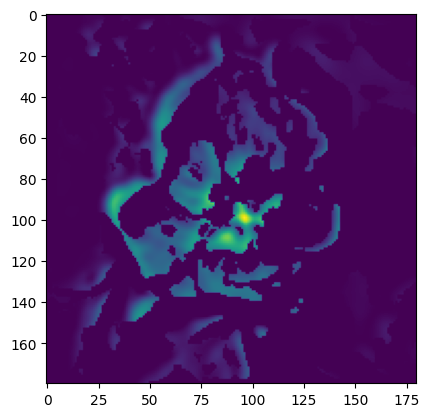

(torch.Size([10, 3]),
 tensor([[0.2667, 0.3125, 0.3092],
         [0.1921, 0.2648, 0.2269],
         [0.3518, 0.3058, 0.3198],
         [0.3201, 0.3928, 0.4718],
         [0.5118, 0.4195, 0.3702],
         [0.2303, 0.2318, 0.2394],
         [0.2878, 0.3262, 0.3446],
         [0.3475, 0.3354, 0.3306],
         [0.3757, 0.3622, 0.3196],
         [0.0771, 0.0678, 0.0593]], device='cuda:0', dtype=torch.float64,
        grad_fn=<DivBackward0>))

In [16]:
from torch.nn.functional import normalize
def build_histogram_orientation(ori_arg_max,_kp1,n_bin):
    #cria mascara para remocao de borda
    _B, _C, _W, _H = _kp1.shape
    print(ori_arg_max.min(),ori_arg_max.max())
    circular_mask = create_circular_mask2(_H,_W)
    print(type(circular_mask),circular_mask.shape)
    hist_batch =None
    for i in range(n_bin):
        v_bin = 360//n_bin
        int_0 = v_bin*i
        int_1 = v_bin*(i+1)
        interval_mask = create_interval_mask(ori_arg_max,int_0,int_1)
        mask_simples  = intersection_filter_interval_mask(interval_mask,torch.tensor(circular_mask[None]))
        sum_b, batch_filtered = sum_filtered_intensity(_kp1,mask_simples)
        print('interval :',int_0," - ",int_1)
        plt.imshow(batch_filtered[0,0].cpu().detach())
        plt.show()
        if hist_batch is None:
            hist_batch = sum_b
        else:
            hist_batch=torch.cat((hist_batch,sum_b),1)
    return  normalize(hist_batch*1.0, p=2, dim = 0)

#Idealmente eu poderia passar um conjunto de features
#com a orientacao max e o seus mapas de ativacao e tamanho de bin
hist1_b = build_histogram_orientation(ori_arg_max,_kp1,num_bin)
hist1_b.shape,hist1_b

### Aplicar o shift dos bin do histograma de modo que o mesmo fique sempre numa mesma posição
- determinar a posição do bin de maior valor 
- realizar o movimento de shift numa determinada direção
- armazena os movimentos
- normaliza o histograma

In [17]:
# realiza shift no histograma de maneira controlada

In [18]:
# normaliza o histograma
p = sum_b*1.0
hist = normalize(p, p=2, dim = 0)
hist

tensor([[0.2720],
        [0.2176],
        [0.3569],
        [0.3530],
        [0.4493],
        [0.2159],
        [0.3194],
        [0.3393],
        [0.3947],
        [0.0726]], device='cuda:0', grad_fn=<DivBackward0>)

### Commentarios
---
Em suma para realização da correspondencia de imagem utilizamos uma estratégia semelhante ao histograma orientado a gradiente aplicado a redes neurais profunda equivalirante a rotação, onde campo de atuação do histograma esta restrito a uma mascara circular.
Dentro da analise do histograma global temos ainda que o maior bin pode ajudar no alinhamento da imagem para encontramos um padrão.

### Testando os matching entre as caracteristicas

- Ja calculamos os histogramas das caracteristicas originais acima
- Calcularemos os histogramas as caracteristicas transformadas
- Nesse exemplo cada imagem representa uma caracteristica, porém no algoritmo final será uma sub-imagem
- Todos os histogramas serão normalizados entre o batch
- compararemos os histogramas original com os transformados para encontrar a correspondencia

torch.Size([10, 1, 180, 180]) torch.Size([10, 36, 180, 180])
tensor(0., device='cuda:0') tensor(350., device='cuda:0')
<class 'numpy.ndarray'> (180, 180)
interval : 0  -  120


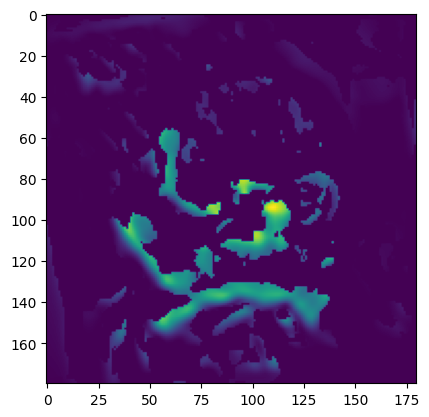

interval : 120  -  240


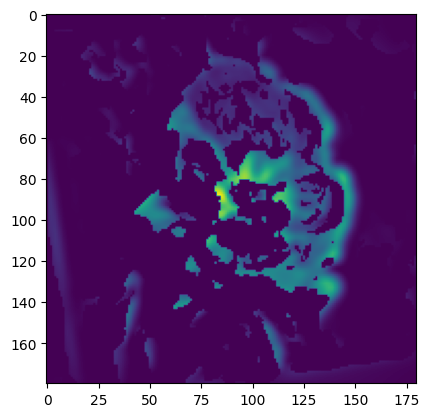

interval : 240  -  360


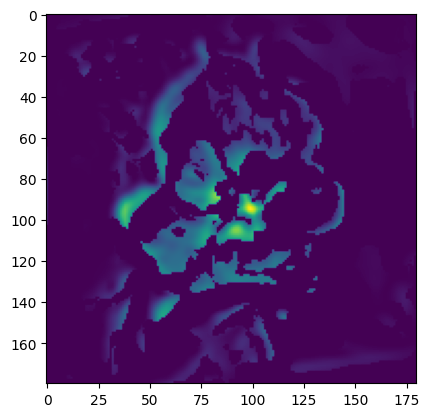

tensor([[0.2709, 0.3195, 0.3014],
        [0.1992, 0.2699, 0.2257],
        [0.3565, 0.3073, 0.3069],
        [0.3316, 0.3783, 0.4753],
        [0.5024, 0.4240, 0.3727],
        [0.2227, 0.2299, 0.2407],
        [0.2937, 0.3216, 0.3589],
        [0.3523, 0.3276, 0.3317],
        [0.3621, 0.3714, 0.3121],
        [0.0797, 0.0790, 0.0713]], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [19]:
print(_kp2.shape, _orie2.shape)
ori2_org_max= compute_gradient_direction(_orie2)

hist2_b = build_histogram_orientation(ori2_org_max,_kp2,num_bin)
hist2_b

In [20]:
print(hist1_b)
print(hist2_b)
for i in range(10):
    d=abs(hist2_b - hist1_b[i])
    diff_hist =torch.sum(d,(1))
    print("index: ",i," found in ",diff_hist.argmin().item()," position ")

tensor([[0.2667, 0.3125, 0.3092],
        [0.1921, 0.2648, 0.2269],
        [0.3518, 0.3058, 0.3198],
        [0.3201, 0.3928, 0.4718],
        [0.5118, 0.4195, 0.3702],
        [0.2303, 0.2318, 0.2394],
        [0.2878, 0.3262, 0.3446],
        [0.3475, 0.3354, 0.3306],
        [0.3757, 0.3622, 0.3196],
        [0.0771, 0.0678, 0.0593]], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)
tensor([[0.2709, 0.3195, 0.3014],
        [0.1992, 0.2699, 0.2257],
        [0.3565, 0.3073, 0.3069],
        [0.3316, 0.3783, 0.4753],
        [0.5024, 0.4240, 0.3727],
        [0.2227, 0.2299, 0.2407],
        [0.2937, 0.3216, 0.3589],
        [0.3523, 0.3276, 0.3317],
        [0.3621, 0.3714, 0.3121],
        [0.0797, 0.0790, 0.0713]], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)
index:  0  found in  0  position 
index:  1  found in  1  position 
index:  2  found in  2  position 
index:  3  found in  3  position 
index:  4  found in  4  position 
index:  5 